In [1]:
import torch
from gan_evaluation import generate_images, pca_images, plot_pca
from utils import get_dataset_custom_training
from CGAN_PyTorch.cgan_pytorch.models.generator import Generator
from CGAN_PyTorch.cgan_pytorch.models.generator import ConvGenerator
from torch.utils.data import DataLoader
import os
from tqdm import tqdm
from gan_evaluation import classifier_accuracy, load_classifier, calculate_emd, plot_cgan_generated_images


# Load the MNIST dataset
_, test_dataset = get_dataset_custom_training('mnist')
testloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [4]:
# Initialize the Generator
generator = ConvGenerator()
# Load the trained model weights
generator.load_state_dict(torch.load(os.path.join('..', 'weights', 'CGAN_mnist_30_100_0.0002_20240601-142724.pth')))
generator.eval()

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator.to(device)

ConvGenerator(
  (label_embedding): Embedding(10, 10)
  (l1): Sequential(
    (0): Linear(in_features=110, out_features=6272, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode=nearest)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Upsample(scale_factor=2.0, mode=nearest)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Tanh()
  )
)

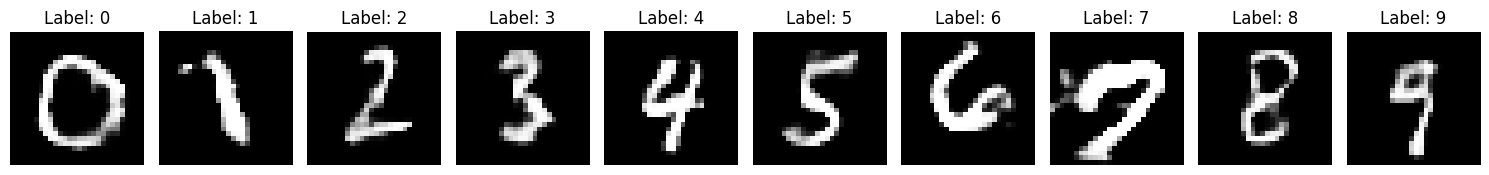

Testing: 100%|██████████| 313/313 [00:05<00:00, 52.78it/s]

Earth Mover's Distance: 1.7718946033697016
Real images accuracy: 0.9913, Fake images accuracy: 0.9592


In [9]:
real_preds = 0
fake_preds = 0
emd_real_images = torch.empty(0, ).to(device)
emd_fake_images = torch.empty(0, ).to(device)
labels_list = torch.empty(0, ).to(device)

model = load_classifier('mnist', model_path=os.path.join('..', 'weights', 'mnist_classifier.pth'))
plot_cgan_generated_images(generator, device, 'mnist', num_classes=10,
                           latent_dim=100)
for batch_idx, (images, labels) in enumerate(tqdm(testloader, f"Testing: ")):
    images = images.to(device)
    labels = labels.to(device)
    fake_images = generate_images(generator, device, labels, num_images=images.size(0), latent_dim=100)
    emd_real_images = torch.cat((emd_real_images, images), dim=0)
    emd_fake_images = torch.cat((emd_fake_images, fake_images), dim=0)
    labels_list = torch.cat((labels_list, labels), dim=0)
    real_preds_temp, fake_preds_temp = classifier_accuracy(model, images, fake_images, labels, 'mnist',
                                                           device)
    real_preds += real_preds_temp
    fake_preds += fake_preds_temp

real_accuracy = real_preds / len(test_dataset)
fake_accuracy = fake_preds / len(test_dataset)

emd = calculate_emd(emd_real_images, emd_fake_images)
# pca_real, pca_fake = pca_images(emd_real_images, emd_fake_images)
# plot_pca(pca_real, pca_fake, labels_list)
print(f"Earth Mover's Distance: {emd}")
print(f"Real images accuracy: {real_accuracy}, Fake images accuracy: {fake_accuracy}")

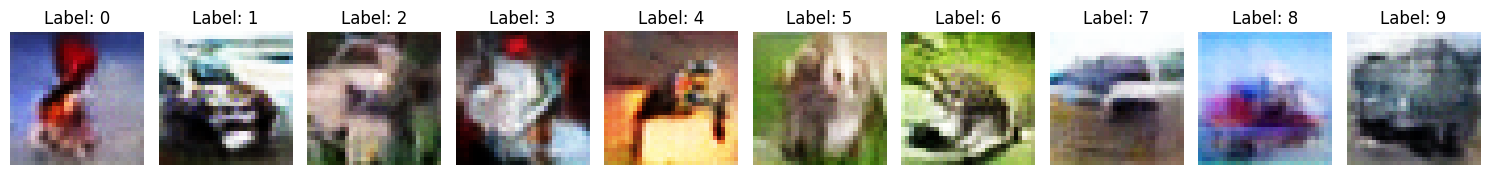

In [6]:
from src.CGAN_PyTorch.cgan_pytorch.models.generator import GeneratorCIFAR

gen = GeneratorCIFAR().to(device)

gen.load_state_dict(torch.load(os.path.join('..', 'weights', 'CGAN_20240531-115557.pth')))

plot_cgan_generated_images(gen, device, 'cifar', num_classes=10,
                           latent_dim=100)